In [25]:
import pandas as pd
import numpy as np
import os
import rebound
from collections import OrderedDict

path = '/scratch/dtamayo/'
icpath = path +'random/initial_conditions/runs/ic'
fcpath = path +'random/final_conditions/runs/fc'

df = pd.read_csv(path+'random/random.csv', index_col=0)

In [248]:
maxorbs = 1e4
Nout = 100
window = 10
Navg = 10

def collision(reb_sim, col):
    reb_sim.contents._status = 5 # causes simulation to stop running and have flag for whether sim stopped due to collision
    return 0
    
def system(row):
    sim = rebound.Simulation.from_file(icpath+row['runstring'])
    ps = sim.particles
    
    sim2 = rebound.Simulation()
    sim2.G = sim.G
    for p in ps:
        sim2.add(p)

    P0 = ps[1].P
    tmax = maxorbs * P0 # number of inner planet orbital periods to integrate
    
    sim.collision_resolve = collision
    sim2.collision_resolve = collision

    kicksize=1.e-11
    sim2.particles[2].x += kicksize
    
    E0 = sim.calculate_energy()
    times = np.linspace(0,tmax,Nout)
    
    a = np.zeros((sim.N,Nout))
    e = np.zeros((sim.N,Nout))
    inc = np.zeros((sim.N,Nout))
    e2shadow = np.zeros(Nout)
    
    Rhill12 = ps[1].a*((ps[1].m+ps[2].m)/3.)**(1./3.)
    Rhill23 = ps[2].a*((ps[2].m+ps[3].m)/3.)**(1./3.)
    
    eHill = [0, Rhill12/ps[1].a, max(Rhill12, Rhill23)/ps[2].a, Rhill23/ps[3].a]
    daOvera = [0, (ps[2].a-ps[1].a)/ps[1].a, min(ps[3].a-ps[2].a, ps[2].a-ps[1].a)/ps[2].a, (ps[3].a-ps[2].a)/ps[3].a]
    
    for i, t in enumerate(times):
        for j in [1,2,3]:
            a[j,i] = ps[j].a
            e[j,i] = ps[j].e
            inc[j,i] = ps[j].inc
        e2shadow[i] = sim2.particles[2].e
        sim.integrate(t)
        sim2.integrate(t)
    
    features = OrderedDict()
    
    simf = rebound.Simulation.from_file(fcpath+row['runstring'])
    features['Stable'] = 1 if np.isclose(simf.t, 1.e9) else 0
    features['instability_time'] = simf.t
    features['Rel_Eerr'] = abs((simf.calculate_energy()-E0)/E0)
        
    features['t_final_short'] = sim.t/P0
    Ef = sim.calculate_energy()
    features['Rel_Eerr_short'] = abs((Ef-E0)/E0)
    
    for j in [1,2,3]:
        for string, feature in [('a', a), ('e', e), ('inc', inc)]:
            mean = feature[j].mean()
            std = feature[j].std()
            features['avg_'+string+str(j)] = mean
            features['std_'+string+str(j)] = std
            features['max_'+string+str(j)] = feature[j].max()
            features['min_'+string+str(j)] = feature[j].min()
            features['norm_std_'+string+str(j)] = std/mean
            features['norm_max_'+string+str(j)] = np.abs(feature[j] - mean).max()/mean
            sample = feature[j][:window]
            samplemean = sample.mean()
            features['norm_std_window'+str(window)+'_'+string+str(j)] = sample.std()/samplemean
            features['norm_max_window'+str(window)+'_'+string+str(j)] = np.abs(sample - samplemean).max()/samplemean

        for string, feature in [('eH', e), ('iH', inc)]:
            mean = feature[j].mean()
            std = feature[j].std()

            features['avg_'+string+str(j)] = mean/eHill[j]
            features['std_'+string+str(j)] = std/eHill[j]
            features['max_'+string+str(j)] = feature[j].max()/eHill[j]
            features['min_'+string+str(j)] = feature[j].min()/eHill[j]

        string, feature = ('ecross', e)
        features['avg_'+string+str(j)] = mean/daOvera[j]
        features['std_'+string+str(j)] = std/daOvera[j]
        features['max_'+string+str(j)] = feature[j].max()/daOvera[j]
        features['min_'+string+str(j)] = feature[j].min()/daOvera[j]

        xx = range(a[j].shape[0])
        yy = a[j]/a[j].mean()/features["t_final_short"]
        par = np.polyfit(xx, yy, 1, full=True)
        features['norm_a'+str(j)+'_slope'] = par[0][0]

    N = min((e[2] > 0).sum(), (e2shadow > 0).sum()) # Number of nonzero entries in each array, in case either go unstable before end of run
    Nfit = N//Navg # N of binned points
    Ntrim = Nfit*Navg # trim array to number that can fit in bins of size Navg
    e2avg = np.average(e[2][:Ntrim].reshape(Nfit, Navg), axis=1) # reshape into Nfit lists of Navg consecutive values and average
    e2shadowavg = np.average(e2shadow[:Ntrim].reshape(Nfit, Navg), axis=1)
    timesavg = np.average(times[:Ntrim].reshape(Nfit, Navg), axis=1)
    e2diff = np.abs(e2avg - e2shadowavg)
    par = np.polyfit(timesavg, np.log10(e2diff), 1, full=True)
    features['Lyapunov_time'] = 1/par[0][0]
    
    return pd.Series(features, index=list(features.keys()), name=row.name)

In [186]:
from rebound import InterruptiblePool
def dorows(params):
    start, end, df = params
    df = df.iloc[start:end]
    return pd.concat([df, df.apply(system, axis=1)], axis=1)

In [259]:
from rebound import InterruptiblePool
def dorows(params):
    start, end, df = params
    first = pd.concat([df.iloc[start], system(df.iloc[start])])
    df_full = pd.DataFrame([first])
    for i in range(start+1,end):
        df_full = df_full.append(pd.concat([df.iloc[i], system(df.iloc[i])]))
        df_full.to_csv('../csvs/tmp/short_integration_features'+str(start)+'.csv', encoding='ascii')

In [258]:
%%time
simIDmax = 13
Nnodes = 4
Npernode = simIDmax // Nnodes
params = [[i*Npernode, (i+1)*Npernode, df] for i in range(Nnodes)]
params[-1][1] = simIDmax

df = pd.read_csv(path+'random/random.csv', index_col=0)
pool = InterruptiblePool(Nnodes)
pool.map(dorows, params)

/mnt/raid-cita/dtamayo/stability/lib/python3.4/site-packages/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/stability/lib/python3.4/site-packages/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/stability/lib/python3.4/site-packages/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/stability/lib/python3.4/site-packages/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


4
1
10
7
5
11
2
8
12
CPU times: user 69 ms, sys: 115 ms, total: 184 ms
Wall time: 43.1 s


In [ ]:
simIDmax = 15000
Nnodes = 10
Npernode = simIDmax // Nnodes
starts = [i*Npernode for i in range(Nnodes)]
dfs = []
for start in starts:
    dfs.append(pd.read_csv('../csvs/tmp/short_integration_features'+str(start)+'.csv', index_col=0))
df = pd.concat(dfs)
df.to_csv('../csvs/short_integration_features.csv', encoding='ascii')

In [264]:
start = 0
df = pd.read_csv('../csvs/tmp/short_integration_features'+str(start)+'.csv', index_col=0)
df.tail()

,runstring,Stable,instability_time,Rel_Eerr,t_final_short,Rel_Eerr_short,avg_a1,std_a1,max_a1,min_a1,...,avg_iH3,std_iH3,max_iH3,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,Lyapunov_time
316,0000316.bin,1.0,1.000000e+09,1.767130e-09,10000.0,1.648162e-09,0.999143,0.000954,1.000446,0.997185,...,0.769881,0.146632,1.030037,0.541611,0.031615,0.006021,0.029139,0.028246,-4.177572e-12,5793.414676
317,0000317.bin,1.0,1.000000e+09,3.511360e-10,10000.0,8.121436e-09,0.999020,0.000474,1.000505,0.998103,...,0.603908,0.070268,0.722846,0.492228,0.035215,0.004097,0.034342,0.005205,-6.761919e-12,-91427.258581
318,0000318.bin,1.0,1.000000e+09,2.288661e-09,10000.0,8.303628e-10,0.999991,0.000005,1.000004,0.999983,...,0.623906,0.154322,0.860850,0.340440,0.032765,0.008104,0.061059,0.054717,-1.618700e-12,3637.459949
319,0000319.bin,1.0,1.000000e+09,1.463871e-09,10000.0,1.189756e-08,0.999974,0.000087,1.000228,0.999853,...,1.084952,0.091550,1.200721,0.896639,0.057930,0.004888,0.030206,0.002490,-2.519943e-12,7351.633170
320,0000320.bin,1.0,1.000000e+09,7.203833e-09,10000.0,2.234387e-09,0.999967,0.000088,1.000334,0.999855,...,1.232461,0.297124,1.830236,0.894471,0.093773,0.022607,0.259307,0.166456,5.644644e-12,7848.006033


In [94]:
df = pd.read_csv('../csvs/initial_orbital_elements.csv', index_col=0)
df.head()

,runstring,Stable,instability_time,Rel_Eerr,RHill12,RHill23,beta12,beta23,m1,a1,...,Omega2,f2,m3,a3,P3,e3,pomega3,inc3,Omega3,f3
0,0000000.bin,0,1.235644e+07,1.099985e-04,0.026033,0.023222,8.508586,15.826967,3.414016e-05,1.0,...,1.573978,-0.567081,1.826900e-06,1.589043,2.003050,0.002515,-0.108162,0.065498,-1.192440,-0.614709
1,0000001.bin,0,1.348749e+05,1.388587e-08,0.022704,0.031284,8.397002,15.367618,2.529838e-07,1.0,...,-1.749616,1.437355,1.955797e-05,1.671403,2.160777,0.072450,-0.343874,0.046939,-0.619350,0.192203
2,0000002.bin,0,1.276381e+04,3.048261e-04,0.036304,0.032149,3.461288,25.229467,7.380789e-05,1.0,...,-0.032550,-0.317958,1.477931e-07,1.936762,2.695151,0.003395,3.419165,0.014535,2.795101,1.685406
3,0000003.bin,1,1.000000e+09,6.492574e-10,0.011704,0.014963,18.513681,19.145889,5.174804e-07,1.0,...,0.946351,-2.294238,1.287851e-06,1.503164,1.842927,0.057380,-0.829096,0.098014,-2.995941,-1.625763
4,0000004.bin,0,8.791888e+01,9.336734e-07,0.006199,0.008634,5.494196,2.928938,5.106746e-07,1.0,...,-0.455684,-1.074927,1.542321e-06,1.059346,1.090326,0.010325,-1.214839,0.011840,-1.253823,1.215392


In [181]:
Nout = 100
maxorbs = 1e4
run = df.loc[1]
sim = rebound.Simulation.from_file(icpath+run['runstring'])
ps = sim.particles

sim2 = rebound.Simulation()
sim2.G = sim.G
for p in ps:
    sim2.add(p)

P0 = ps[1].P
tmax = maxorbs * P0 # number of inner planet orbital periods to integrate

sim.collision_resolve = collision
sim2.collision_resolve = collision

kicksize=1.e-11
sim2.particles[2].x += kicksize

E0 = sim.calculate_energy()
times = np.linspace(0,tmax,Nout)

a = np.zeros((sim.N,Nout))
e = np.zeros((sim.N,Nout))
inc = np.zeros((sim.N,Nout))
e2shadow = np.zeros(Nout)

Rhill12 = ps[1].a*((ps[1].m+ps[2].m)/3.)**(1./3.)
Rhill23 = ps[2].a*((ps[2].m+ps[3].m)/3.)**(1./3.)

eHill = [0, Rhill12/ps[1].a, max(Rhill12, Rhill23)/ps[2].a, Rhill23/ps[3].a]
daOvera = [0, (ps[2].a-ps[1].a)/ps[1].a, min(ps[3].a-ps[2].a, ps[2].a-ps[1].a)/ps[2].a, (ps[3].a-ps[2].a)/ps[3].a]

for i, t in enumerate(times):
    for j in [1,2,3]:
        a[j,i] = ps[j].a
        e[j,i] = ps[j].e
        inc[j,i] = ps[j].inc
    e2shadow[i] = sim2.particles[2].e
    sim.integrate(t, exact_finish_time=0)
    sim2.integrate(t, exact_finish_time=0)
  
N = min((e[2] > 0).sum(), (e2shadow > 0).sum()) # Number of nonzero entries in each array, in case either go unstable before end of run
#N = (np.abs(e[2]-e2shadow) < 1.e-5).sum() # Number of nonzero entries in each array, in case either go unstable before end of run
Nfit = N//Navg # N of binned points
Ntrim = Nfit*Navg # trim array to number that can fit in bins of size Navg
e2avg = np.average(e[2][:Ntrim].reshape(Nfit, Navg), axis=1) # reshape into Nfit lists of Navg consecutive values and average
e2shadowavg = np.average(e2shadow[:Ntrim].reshape(Nfit, Navg), axis=1)
timesavg = np.average(times[:Ntrim].reshape(Nfit, Navg), axis=1)
e2diff = np.abs(e2avg - e2shadowavg)
par = np.polyfit(timesavg, np.log10(e2diff), 1, full=True)
print(1/par[0][0])
    

/mnt/raid-cita/dtamayo/stability/lib/python3.4/site-packages/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


3278.83298347


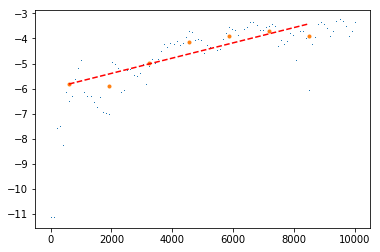

In [182]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
mean = a[1].mean()
ax.plot(times, np.log10(np.abs(e[2]-e2shadow)), ',')
ax.plot(timesavg, np.log10(e2diff), '.')
ax.plot(timesavg, par[0][0]*timesavg+par[0][1], 'r--')

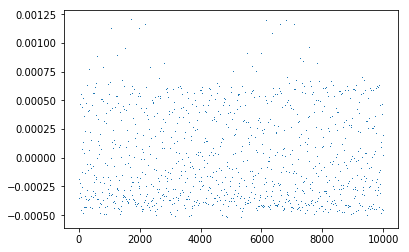

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
mean = a[1].mean()
ax.plot(times, (a[1]-mean)/mean, ',')
#ax.set_xlim([0,20])

(0, 0.08)

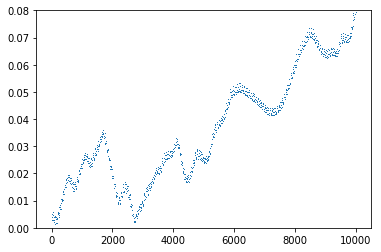

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(times, e[3], ',')
ax.set_ylim([0,0.08])

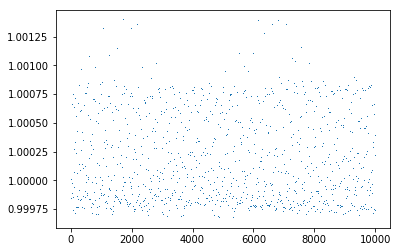

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(times, a[1], ',')
#ax.set_xlim([0,20])

In [68]:
df.to_csv('../data/1e7data_train.csv', encoding='ascii')
dftest.to_csv('../data/1e7data_holdout.csv', encoding='ascii')